In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy import units as u
from astropy import constants as c
e = c.e.esu

from scipy.special import wofz

from astro530 import partition, saha_phi, P_e, K_total, KH_bf, KH_ff, KHminus_bf, KHminus_ff, K_e

plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [2]:
u_table = pd.read_table('./data/RepairedPartitionFunctions.txt', header=None, na_values='-', delim_whitespace=True)
u_table = u_table.set_index(0)

i_table = pd.read_table('./data/nist_ioniz.txt', header=None , delim_whitespace= True)
i_table = i_table.set_index(1)

A_table = pd.read_table('./data/SolarAbundance.txt', delim_whitespace= True)
A_table.dropna(inplace=True)

elements = A_table['element'].to_list()
elements.remove('Cs')

A_table = A_table.set_index('element')

VALIIIC = pd.read_pickle('./data/VALIIIC_atm.pkl')

In [3]:
weight = A_table['weight']
m_Na = weight['Na'] * u.u

I_Na = i_table.loc['Na'][3] * u.eV

D_lines = np.array([5895.932, 5889.959]) * u.AA

In [4]:
def C_6(l0, I):
    chi_l = (c.h * c.c / l0).to(u.eV).value
    I = I.to(u.eV).value
    C6 = 0.3e-30 * (1/(I - chi_l)**2 - 1/I**2)
    return C6

print(np.log10(C_6(D_lines, I_Na)))

[-31.67399329 -31.67305612]


In [5]:
def gamma_4(T, Pe, log_C4):
    Pe = Pe / u.barye
    T = T / u.K
    log_gamma4 = 19 + 2/3 * log_C4 + np.log10(Pe) - 5/6 * np.log10(T)
    return 10 ** log_gamma4 * 1/u.s

def gamma_6(T, Pg, log_C6):
    Pg = Pg / u.barye
    T = T / u.K
    log_gamma6 = 20 + 0.4 * log_C6 + np.log10(Pg) - 0.7 * np.log10(T)
    return 10 ** log_gamma6 * 1/u.s


def gamma(T, Pg, Pe, A_ul,log_C4, log_C6):
    gamma_rad = A_ul
    gamma4 = gamma_4(T, Pe,log_C4)
    gamma6 = gamma_6(T, Pg, log_C6)
    return gamma_rad + gamma4 + gamma6

In [6]:
def gaussian_width(l0, T, micro):
    m_Na = 22.99 * u.u
    therm = 2 * c.k_B * T / m_Na
    return l0 / c.c * np.sqrt(therm + micro**2)

In [7]:
def Hjerting(u, a):
    return np.real(wofz(u + 1j*a)) 

In [56]:
def osc_f(l, g_l, g_u, A_ul):
    A_gray = A_ul/ (4 * np.pi)
    l = l.to(u.AA).value
    return 1.884e-15 * g_u / g_l * l**2 * A_gray.value

def alpha_NaD(l, T, Pg, Pe, micro, which):
    
    i = which - 1
    
    l0 = np.array([5895.932, 5889.959]) * u.AA
    A_ul = np.array([0.614, 0.616]) * 10 ** 8 * 1/u.s
    log_C4 = np.array([-15.33, -15.17])
    log_C6 = np.array([-31.673, -31.674])
    
    g_l = np.array([2, 2]) 
    g_u = np.array([2, 4])
    
    g = gamma(T, Pg, Pe, A_ul[i], log_C4[i], log_C6[i]) / c.c * l0[i]**2
    Dl = gaussian_width(l0[i], T, micro) 
    
    a = g /(4 * np.pi * Dl)
    v = (l - l0[i]) / Dl

    H = Hjerting(v, a)  
    
    f = osc_f(l,g_l[i], g_u[i], A_ul[i])
    
    return np.sqrt(np.pi) * e**2 / (c.m_e * c.c**2) * f * H / Dl * l0[i]**2

In [57]:
tau_500 = VALIIIC['tau_500']

T = VALIIIC['T'][48] * u.K
Pg = VALIIIC['Pgas/Ptotal'][48] * VALIIIC['Ptotal'][48] * u.barye
Pe = P_e(T, Pg, A_table, i_table, u_table, elements)
micro = VALIIIC['V'][48] * u.km/u.s
rho = VALIIIC['rho'][48] * u.g/u.cm**3
nH = VALIIIC['n_H'][48] * u.cm**-3

In [58]:
wvlen = np.linspace(5876, 5911, 1000) * u.AA

In [59]:
Dlambda = gaussian_width(D_lines, T, micro)
for i in range(2):
    print('lambda_0 = ' + str(D_lines[i]))
    print('Dlambda_D = ' + '{:.4f}'.format(Dlambda.to(u.AA)[i].value))
    print('Stim. emission factor = ' + '{:.3f}'.format(1 - np.exp(-c.h * c.c / (D_lines[i] * c.k_B * T))))
    print('\n')

lambda_0 = 5895.932 Angstrom
Dlambda_D = 0.0528
Stim. emission factor = 0.978


lambda_0 = 5889.959 Angstrom
Dlambda_D = 0.0527
Stim. emission factor = 0.978




In [60]:
alpha_NaD1 = alpha_NaD(wvlen, T, Pg, Pe, micro, 1).cgs.value
alpha_NaD2 = alpha_NaD(wvlen, T, Pg, Pe, micro, 2).cgs.value

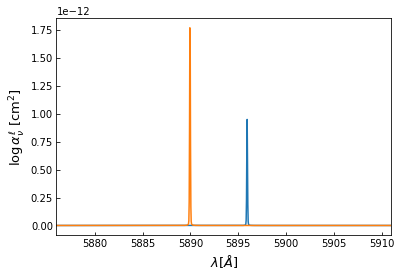

In [61]:
plt.plot(wvlen, alpha_NaD1)
plt.plot(wvlen, alpha_NaD2)
plt.ylabel(r'$\log \alpha^\ell_\nu$ [cm$^2$]')
plt.xlabel(r'$\lambda [\AA]$')
plt.show()

In [62]:
def K_NaD(l, T, Pg, Pe, micro, which):
    A_Na = 2.14e-6
    f_e = 2/partition('Na', T, u_table)
    Phi_Na = saha_phi('Na', T, i_table, u_table)
    f_i = 1 / (1 + Phi_Na / Pe)
    
    alpha = alpha_NaD(l, T, Pg, Pe, micro, which).cgs 
    stim = 1 - np.exp(-c.h * c.c / (l * c.k_B * T))
    return alpha * nH / rho * A_Na * f_e * f_i * stim

In [63]:
A_j = A_table.loc[elements]['A'].to_numpy()
mu = np.sum(A_table.loc[elements]['A'] * A_table.loc[elements]['weight'] * u.u).cgs

def to_cm2g(K, T, Pe, mu, H=True):
    if H:
        Phi_H = saha_phi('H', T, i_table, u_table)
        neutral_H = 1 / (1 + Phi_H / Pe)
        K *= neutral_H 
    per_g = K / mu
    return per_g

In [64]:
naD1 = K_NaD(wvlen, T, Pg, Pe, micro, 1).cgs.value
naD2 = K_NaD(wvlen, T, Pg, Pe, micro, 2).cgs.value

continuum = u.Quantity([K_total(wvlen[i], T, Pg, Pe, A_table, i_table, u_table, elements) for i in range(len(wvlen))]).cgs.value

Hbf = to_cm2g(KH_bf(wvlen, T, i_table), T, Pe, mu).cgs.value
Hff = to_cm2g(KH_ff(wvlen, T, i_table), T, Pe, mu).cgs.value
Hminus_bf = to_cm2g(KHminus_bf(wvlen, T, Pe), T, Pe, mu).cgs.value
Hminus_ff = to_cm2g(KHminus_ff(wvlen, T, Pe), T, Pe, mu).cgs.value
electrons = to_cm2g(K_e(Pg, Pe, A_j), T, Pe, mu, H=False).cgs.value

In [53]:
# l = np.array([5889.959, 5893, 5895.932]) * u.AA

# K_NaD1_l = K_NaD1(wvlen).cgs.value
# K_NaD2_l = K_NaD2(wvlen).cgs.value

# print('\t '.join(['{:.0f}'.format(l[i].value) for i in range(3)]))
# print(' '.join(['{:.2e}'.format(K_NaD1_l[i]) for i in range(3)]))
# print(' '.join(['{:.2e}'.format(K_NaD2_l[i]) for i in range(3)]))
# print('\n')

# Kc = u.Quantity([K_total(l[i], T, Pg, Pe, A_table, i_table, u_table, elements, verbose=True) for i in range(len(l))]).cgs.value

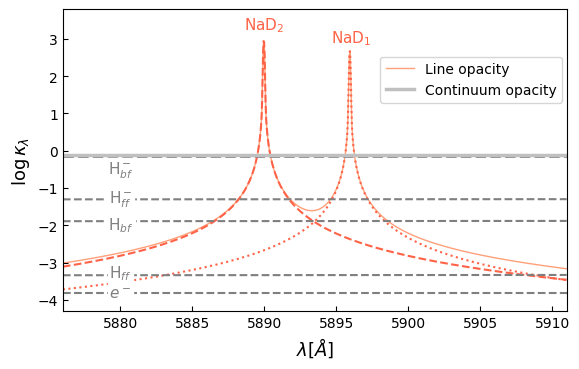

In [65]:
plt.figure(figsize=(6.5,4), dpi=100)
plt.plot(wvlen, np.log10(naD1),c='tomato', ls=':')
plt.text(5890, 3.25, 'NaD$_2$', ha='center', color='tomato', size=11)

plt.plot(wvlen, np.log10(naD2),c='tomato', ls='--')
plt.text(5896, 2.9, 'NaD$_1$', ha='center', color='tomato', size=11)

plt.plot(wvlen, np.log10(naD1 + naD2), c='lightsalmon', lw=1, zorder=0, label =r'Line opacity')

plt.plot(wvlen, np.log10(Hbf), 'C7--')
plt.text(5880, -2.1, r'H$_{bf}$', ha='center', color='C7', size=11, bbox=dict(boxstyle='Square, pad=0.1', color='white'), zorder=10)

plt.plot(wvlen, np.log10(Hff), 'C7--')
plt.text(5880, -3.4, r'H$_{ff}$', ha='center', color='C7', size=11, bbox=dict(boxstyle='Square, pad=0.1', color='white'))


plt.plot(wvlen, np.log10(Hminus_bf),'C7--', lw=2)
plt.text(5880, -0.6, r'H$^-_{bf}$', ha='center', color='C7', size=11, bbox=dict(boxstyle='Square, pad=0.1', color='white', alpha=0.8))

plt.plot(wvlen, np.log10(Hminus_ff),'C7--')
plt.text(5880, -1.4, r'H$^-_{ff}$', ha='center', color='C7', size=11, bbox=dict(boxstyle='Square, pad=0.1', color='white'))


plt.hlines(np.log10(electrons), 5876, 5911, 'C7', '--')
plt.text(5880, -3.95, r'$e^-$', ha='center', color='C7', size=11, bbox=dict(boxstyle='Square, pad=0.1', color='white'))

plt.plot(wvlen, np.log10(continuum), c='silver', ls = '-', label =r'Continuum opacity',lw=2.5, )

#plt.plot(wvlen, np.log10(naD1 + naD2 + continuum), 'k-', lw=1, label =r'$\kappa_{tot}$')
plt.ylabel(r'$\log \kappa_\lambda$')
plt.xlabel(r'$\lambda [\AA]$')

plt.ylim(-4.3, 3.8)

plt.legend(loc = (0.63, 0.69))

plt.savefig('NaD_kappa.png', bbox_inches='tight')
plt.show()